In [1]:
import numpy as np # linear algebra
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score
import joblib
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import LabelEncoder

# this only transforms the idhogar field, the other things this function used to do are done elsewhere
def encode_data(df):
    df['idhogar'] = LabelEncoder().fit_transform(df['idhogar'])

# plot feature importance for sklearn decision trees    
def feature_importance(forest, X_train, display_results=True):
    ranked_list = []
    zero_features = []
    
    importances = forest.feature_importances_

    indices = np.argsort(importances)[::-1]
    
    if display_results:
        # Print the feature ranking
        print("Feature ranking:")

    for f in range(X_train.shape[1]):
        if display_results:
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) + " - " + X_train.columns[indices[f]])
        
        ranked_list.append(X_train.columns[indices[f]])
        
        if importances[indices[f]] == 0.0:
            zero_features.append(X_train.columns[indices[f]])
            
    return ranked_list, zero_features

In [3]:
def do_features(df):
    feats_div = [('children_fraction', 'r4t1', 'r4t3'), 
                 ('working_man_fraction', 'r4h2', 'r4t3'),
                 ('all_man_fraction', 'r4h3', 'r4t3'),
                 ('human_density', 'tamviv', 'rooms'),
                 ('human_bed_density', 'tamviv', 'bedrooms'),
                 ('rent_per_person', 'v2a1', 'r4t3'),
                 ('rent_per_room', 'v2a1', 'rooms'),
                 ('mobile_density', 'qmobilephone', 'r4t3'),
                 ('tablet_density', 'v18q1', 'r4t3'),
                 ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density', 'v18q1', 'r4t2'),
                ]
    
    feats_sub = [('people_not_living', 'tamhog', 'tamviv'),
                 ('people_weird_stat', 'tamhog', 'r4t3')]

    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32)       
    for f_new, f1, f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32)
    
    # aggregation rules over household
    aggs_num = {'age': ['min', 'max', 'mean'],
                'escolari': ['min', 'max', 'mean']
               }
    
    aggs_cat = {'dis': ['mean']}
    for s_ in ['estadocivil', 'parentesco', 'instlevel']:
        for f_ in [f_ for f_ in df.columns if f_.startswith(s_)]:
            aggs_cat[f_] = ['mean', 'count']

    # aggregation over household
    for name_, df_ in [('18', df.query('age >= 18'))]:
        df_agg = df_.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32)
        df_agg.columns = pd.Index(['agg' + name_ + '_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
        df = df.join(df_agg, how='left', on='idhogar')
        del df_agg

    # Drop id's
    df.drop(['Id'], axis=1, inplace=True)
    
    return df

In [4]:
# convert one hot encoded fields to label encoding
def convert_OHE2LE(df):
    tmp_df = df.copy(deep=True)
    for s_ in ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu', 
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco', 
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']:
        if 'manual_' not in s_:
            cols_s_ = [f_ for f_ in df.columns if f_.startswith(s_)]
        elif 'elec' in s_:
            cols_s_ = ['public', 'planpri', 'noelec', 'coopele']
        sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
        #deal with those OHE, where there is a sum over columns == 0
        if 0 in sum_ohe:
            print('The OHE in {} is incomplete. A new column will be added before label encoding'
                  .format(s_))
            # dummy colmn name to be added
            col_dummy = s_+'_dummy'
            # add the column to the dataframe
            tmp_df[col_dummy] = (tmp_df[cols_s_].sum(axis=1) == 0).astype(np.int8)
            # add the name to the list of columns to be label-encoded
            cols_s_.append(col_dummy)
            # proof-check, that now the category is complete
            sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
            if 0 in sum_ohe:
                 print("The category completion did not work")
        tmp_cat = tmp_df[cols_s_].idxmax(axis=1)
        tmp_df[s_ + '_LE'] = LabelEncoder().fit_transform(tmp_cat).astype(np.int16)
        if 'parentesco1' in cols_s_:
            cols_s_.remove('parentesco1')
        tmp_df.drop(cols_s_, axis=1, inplace=True)
    return tmp_df

# 데이터 불러오기

In [5]:
train = pd.read_csv('./costarica_train.csv')
test = pd.read_csv('./costarica_test.csv')

test_ids = test.Id

In [6]:
def process_df(df_):
    # encode the idhogar
    encode_data(df_)
    
    # create aggregate features
    return do_features(df_)

train = process_df(train)
test = process_df(test)

In [7]:
# some dependencies are Na, fill those with the square root of the square
train['dependency'] = np.sqrt(train['SQBdependency'])
test['dependency'] = np.sqrt(test['SQBdependency'])

# fill "no"s for education with 0s
train.loc[train['edjefa'] == "no", "edjefa"] = 0
train.loc[train['edjefe'] == "no", "edjefe"] = 0
test.loc[test['edjefa'] == "no", "edjefa"] = 0
test.loc[test['edjefe'] == "no", "edjefe"] = 0

# if education is "yes" and person is head of household, fill with escolari
train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "edjefa"] = train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "escolari"]
train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "edjefe"] = train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "escolari"]

test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "edjefa"] = test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "escolari"]
test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "edjefe"] = test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
train.loc[train['edjefa'] == "yes", "edjefa"] = 4
train.loc[train['edjefe'] == "yes", "edjefe"] = 4

test.loc[test['edjefa'] == "yes", "edjefa"] = 4
test.loc[test['edjefe'] == "yes", "edjefe"] = 4

# convert to int for our models
train['edjefe'] = train['edjefe'].astype("int")
train['edjefa'] = train['edjefa'].astype("int")
test['edjefe'] = test['edjefe'].astype("int")
test['edjefa'] = test['edjefa'].astype("int")

# create feature with max education of either head of household
train['edjef'] = np.max(train[['edjefa','edjefe']], axis=1)
test['edjef'] = np.max(test[['edjefa','edjefe']], axis=1)

# fill some nas
train['v2a1']=train['v2a1'].fillna(0)
test['v2a1']=test['v2a1'].fillna(0)

test['v18q1']=test['v18q1'].fillna(0)
train['v18q1']=train['v18q1'].fillna(0)

train['rez_esc']=train['rez_esc'].fillna(0)
test['rez_esc']=test['rez_esc'].fillna(0)

train.loc[train.meaneduc.isnull(), "meaneduc"] = 0
train.loc[train.SQBmeaned.isnull(), "SQBmeaned"] = 0

test.loc[test.meaneduc.isnull(), "meaneduc"] = 0
test.loc[test.SQBmeaned.isnull(), "SQBmeaned"] = 0

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "v14a"] = 0
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "sanitario1"] = 0

test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "v14a"] = 0
test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "sanitario1"] = 0

In [8]:
def train_test_apply_func(train_, test_, func_):
    test_['Target'] = 0
    xx = pd.concat([train_, test_])

    xx_func = func_(xx)
    train_ = xx_func.iloc[:train_.shape[0], :]
    test_  = xx_func.iloc[train_.shape[0]:, :].drop('Target', axis=1)

    del xx, xx_func
    return train_, test_

In [9]:
train, test = train_test_apply_func(train, test, convert_OHE2LE)

The OHE in techo is incomplete. A new column will be added before label encoding
The OHE in instlevel is incomplete. A new column will be added before label encoding
The OHE in manual_elec is incomplete. A new column will be added before label encoding


# Geo aggregates

In [10]:
cols_2_ohe = ['eviv_LE', 'etecho_LE', 'epared_LE', 'elimbasu_LE', 
              'energcocinar_LE', 'sanitario_LE', 'manual_elec_LE',
              'pared_LE']
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

def convert_geo2aggs(df_):
    tmp_df = pd.concat([df_[(['lugar_LE', 'idhogar']+cols_nums)],
                        pd.get_dummies(df_[cols_2_ohe], 
                                       columns=cols_2_ohe)],axis=1)

    geo_agg = tmp_df.groupby(['lugar_LE','idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
    geo_agg.columns = pd.Index(['geo_' + e for e in geo_agg.columns.tolist()])
    
    del tmp_df
    return df_.join(geo_agg, how='left', on='lugar_LE')

# add some aggregates by geography
train, test = train_test_apply_func(train, test, convert_geo2aggs)

In [11]:
train['num_over_18'] = 0
train['num_over_18'] = train[train.age >= 18].groupby('idhogar').transform("count")
train['num_over_18'] = train.groupby("idhogar")["num_over_18"].transform("max")
train['num_over_18'] = train['num_over_18'].fillna(0)

test['num_over_18'] = 0
test['num_over_18'] = test[test.age >= 18].groupby('idhogar').transform("count")
test['num_over_18'] = test.groupby("idhogar")["num_over_18"].transform("max")
test['num_over_18'] = test['num_over_18'].fillna(0)

# add some extra features, these were taken from another kernel
def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms'] # tamhog - size of the household
    df['r4t3_to_tamhog'] = df['r4t3']/df['tamhog'] # r4t3 - Total persons in the household
    df['r4t3_to_rooms'] = df['r4t3']/df['rooms'] # r4t3 - Total persons in the household
    df['v2a1_to_r4t3'] = df['v2a1']/df['r4t3'] # rent to people in household
    df['v2a1_to_r4t3'] = df['v2a1']/(df['r4t3'] - df['r4t1']) # rent to people under age 12
    df['hhsize_to_rooms'] = df['hhsize']/df['rooms'] # rooms per person
    df['rent_to_hhsize'] = df['v2a1']/df['hhsize'] # rent to household size
    df['rent_to_over_18'] = df['v2a1']/df['num_over_18']
    # some households have no one over 18, use the total rent for those
    df.loc[df.num_over_18 == 0, "rent_to_over_18"] = df[df.num_over_18 == 0].v2a1
    
extract_features(train)    
extract_features(test)   


In [12]:
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v18q', 'v14a', 'agesq',
                 'mobilephone', 'female', ]

instlevel_cols = [s for s in train.columns.tolist() if 'instlevel' in s]

needless_cols.extend(instlevel_cols)

train = train.drop(needless_cols, axis=1)
test = test.drop(needless_cols, axis=1)

# Split Data

In [13]:
def split_data(train, y, sample_weight=None, households=None, test_percentage=0.20, seed=None):
    # uncomment for extra randomness
#     np.random.seed(seed=seed)
    
    train2 = train.copy()
    
    # pick some random households to use for the test data
    cv_hhs = np.random.choice(households, size=int(len(households) * test_percentage), replace=False)
    
    # select households which are in the random selection
    cv_idx = np.isin(households, cv_hhs)
    X_test = train2[cv_idx]
    y_test = y[cv_idx]

    X_train = train2[~cv_idx]
    y_train = y[~cv_idx]
    
    if sample_weight is not None:
        y_train_weights = sample_weight[~cv_idx]
        return X_train, y_train, X_test, y_test, y_train_weights
    
    return X_train, y_train, X_test, y_test

In [14]:
X = train.query('parentesco1==1')
# X = train.copy()

# pull out and drop the target variable
y = X['Target'] - 1
X = X.drop(['Target'], axis=1)

np.random.seed(seed=None)

train2 = X.copy()

train_hhs = train2.idhogar

households = train2.idhogar.unique()
cv_hhs = np.random.choice(households, size=int(len(households) * 0.15), replace=False)

cv_idx = np.isin(train2.idhogar, cv_hhs)

X_test = train2[cv_idx]
y_test = y[cv_idx]

X_train = train2[~cv_idx]
y_train = y[~cv_idx]

# train on entire dataset
X_train = train2
y_train = y

train_households = X_train.idhogar

In [15]:
y_train_weights = class_weight.compute_sample_weight('balanced', y_train, indices=None)

In [16]:
extra_drop_features = [
 'agg18_estadocivil1_MEAN',
 'agg18_estadocivil6_COUNT',
 'agg18_estadocivil7_COUNT',
 'agg18_parentesco10_COUNT',
 'agg18_parentesco11_COUNT',
 'agg18_parentesco12_COUNT',
 'agg18_parentesco1_COUNT',
 'agg18_parentesco2_COUNT',
 'agg18_parentesco3_COUNT',
 'agg18_parentesco4_COUNT',
 'agg18_parentesco5_COUNT',
 'agg18_parentesco6_COUNT',
 'agg18_parentesco7_COUNT',
 'agg18_parentesco8_COUNT',
 'agg18_parentesco9_COUNT',
 'geo_elimbasu_LE_4',
 'geo_energcocinar_LE_1',
 'geo_energcocinar_LE_2',
 'geo_epared_LE_0',
 'geo_hogar_mayor',
 'geo_manual_elec_LE_2',
 'geo_pared_LE_3',
 'geo_pared_LE_4',
 'geo_pared_LE_5',
 'geo_pared_LE_6',
 'num_over_18',
 'parentesco_LE',
 'rez_esc']

In [17]:
xgb_drop_cols = extra_drop_features + ["idhogar",  'parentesco1']

In [18]:
opt_parameters = {'max_depth':35, 'eta':0.1, 'silent':0, 'objective':'multi:softmax', 'min_child_weight': 1, 'num_class': 4, 'gamma': 2.0, 'colsample_bylevel': 0.9, 'subsample': 0.84, 'colsample_bytree': 0.88, 'reg_lambda': 0.40 }
# 5
opt_parameters = {'max_depth':35, 'eta':0.15, 'silent':1, 'objective':'multi:softmax', 'min_child_weight': 2, 'num_class': 4, 'gamma': 2.5, 'colsample_bylevel': 1, 'subsample': 0.95, 'colsample_bytree': 0.85, 'reg_lambda': 0.35 }
# 6
# opt_parameters = {'max_depth':35, 'eta':0.15, 'silent':0, 'objective':'multi:softmax', 'min_child_weight': 2, 'num_class': 4, 'gamma': 2.75, 'colsample_bylevel': 0.95, 'subsample': 0.95, 'colsample_bytree': 0.85, 'reg_lambda': 0.35 }
# # 7
# opt_parameters = {'max_depth':35, 'eta':0.12, 'silent':0, 'objective':'multi:softmax', 'min_child_weight': 2, 'num_class': 4, 'gamma': 3.25, 'colsample_bylevel': 0.95, 'subsample': 0.88, 'colsample_bytree': 0.88, 'reg_lambda': 0.35 }

def evaluate_macroF1_lgb(predictions, truth):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.argmax(axis=1)
    truth = truth.get_label()
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', 1-f1) 

fit_params={"early_stopping_rounds":500,
            "eval_metric" : evaluate_macroF1_lgb, 
            "eval_set" : [(X_train,y_train), (X_test,y_test)],
            'verbose': False,
           }

def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.995, current_iter)
    return max(lr, min_learning_rate)

fit_params['verbose'] = 50

In [19]:
np.random.seed(100)

def _parallel_fit_estimator(estimator1, X, y, sample_weight=None, threshold=True, **fit_params):
    estimator = clone(estimator1)
    
    # randomly split the data so we have a test set for early stopping
    if sample_weight is not None:
        X_train, y_train, X_test, y_test, y_train_weight = split_data(X, y, sample_weight, households=train_households)
    else:
        X_train, y_train, X_test, y_test = split_data(X, y, None, households=train_households)
        
    # update the fit params with our new split
    fit_params["eval_set"] = [(X_test,y_test)]
    
    # fit the estimator
    if sample_weight is not None:
        if isinstance(estimator1, ExtraTreesClassifier) or isinstance(estimator1, RandomForestClassifier):
            estimator.fit(X_train, y_train)
        else:
            _ = estimator.fit(X_train, y_train, sample_weight=y_train_weight, **fit_params)
    else:
        if isinstance(estimator1, ExtraTreesClassifier) or isinstance(estimator1, RandomForestClassifier):
            estimator.fit(X_train, y_train)
        else:
            _ = estimator.fit(X_train, y_train, **fit_params)
    
    if not isinstance(estimator1, ExtraTreesClassifier) and not isinstance(estimator1, RandomForestClassifier) and not isinstance(estimator1, xgb.XGBClassifier):
        best_cv_round = np.argmax(estimator.evals_result_['validation_0']['mlogloss'])
        best_cv = np.max(estimator.evals_result_['validation_0']['mlogloss'])
        best_train = estimator.evals_result_['train']['macroF1'][best_cv_round]
    else:
        best_train = f1_score(y_train, estimator.predict(X_train), average="macro")
        best_cv = f1_score(y_test, estimator.predict(X_test), average="macro")
        print("Train F1:", best_train)
        print("Test F1:", best_cv)
        
    # reject some estimators based on their performance on train and test sets
    if threshold:
        # if the valid score is very high we'll allow a little more leeway with the train scores
        if ((best_cv > 0.37) and (best_train > 0.75)) or ((best_cv > 0.44) and (best_train > 0.65)):
            return estimator

        # else recurse until we get a better one
        else:
            print("Unacceptable!!! Trying again...")
            return _parallel_fit_estimator(estimator1, X, y, sample_weight=sample_weight, **fit_params)
    
    else:
        return estimator
    
class VotingClassifierLGBM(VotingClassifier):
    '''
    This implements the fit method of the VotingClassifier propagating fit_params
    '''
    def fit(self, X, y, sample_weight=None, threshold=True, **fit_params):
        
        if isinstance(y, np.ndarray) and len(y.shape) > 1 and y.shape[1] > 1:
            raise NotImplementedError('Multilabel and multi-output'
                                      ' classification is not supported.')

        if self.voting not in ('soft', 'hard'):
            raise ValueError("Voting must be 'soft' or 'hard'; got (voting=%r)"
                             % self.voting)

        if self.estimators is None or len(self.estimators) == 0:
            raise AttributeError('Invalid `estimators` attribute, `estimators`'
                                 ' should be a list of (string, estimator)'
                                 ' tuples')

        if (self.weights is not None and
                len(self.weights) != len(self.estimators)):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d estimators'
                             % (len(self.weights), len(self.estimators)))

        names, clfs = zip(*self.estimators)
        self._validate_names(names)

        n_isnone = np.sum([clf is None for _, clf in self.estimators])
        if n_isnone == len(self.estimators):
            raise ValueError('All estimators are None. At least one is '
                             'required to be a classifier!')

        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        self.estimators_ = []

        transformed_y = self.le_.transform(y)

        self.estimators_ = joblib.Parallel(n_jobs=self.n_jobs)(
                joblib.delayed(_parallel_fit_estimator)(clone(clf), X, transformed_y,
                                                 sample_weight=sample_weight, threshold=threshold, **fit_params)
                for clf in clfs if clf is not None)

        return self

In [20]:
clfs = []
for i in range(15):
    clf = xgb.XGBClassifier(random_state=217+i, n_estimators=300, learning_rate=0.15, n_jobs=4, **opt_parameters)
    
    clfs.append(('xgb{}'.format(i), clf))
    
vc = VotingClassifierLGBM(clfs, voting='soft')
del(clfs)

#Train the final model with learning rate decay
_ = vc.fit(X_train.drop(xgb_drop_cols, axis=1), y_train, sample_weight=y_train_weights, threshold=False, **fit_params)

clf_final = vc.estimators_[0]

[12:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.29894	validation_0-macroF1:0.63874
[50]	validation_0-mlogloss:0.89615	validation_0-macroF1:0.56756
[100]	validation_0-mlogloss:0.89371	validation_0-macroF1:0.55565
[150]	validation_0-mlogloss:0.89062	validation_0-macroF1:0.56537
[200]	validation_0-mlogloss:0.89161	validation_0

[250]	validation_0-mlogloss:0.90326	validation_0-macroF1:0.58032
[299]	validation_0-mlogloss:0.90476	validation_0-macroF1:0.57784
Train F1: 0.9131085061977701
Test F1: 0.42540312297831107
[12:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.30457	validation_0-macroF1:0.66229
[50]	validation_0-mlogloss:0.92731	validation_0-macroF

[100]	validation_0-mlogloss:0.91136	validation_0-macroF1:0.58107
[150]	validation_0-mlogloss:0.90792	validation_0-macroF1:0.56804
[200]	validation_0-mlogloss:0.90564	validation_0-macroF1:0.56718
[250]	validation_0-mlogloss:0.90621	validation_0-macroF1:0.56815
[299]	validation_0-mlogloss:0.90505	validation_0-macroF1:0.57516
Train F1: 0.9216674147144617
Test F1: 0.43368257176436975
[12:38:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:38:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlo

In [21]:
global_score = f1_score(y_test, clf_final.predict(X_test.drop(xgb_drop_cols, axis=1)), average='macro')
vc.voting = 'soft'
global_score_soft = f1_score(y_test, vc.predict(X_test.drop(xgb_drop_cols, axis=1)), average='macro')
vc.voting = 'hard'
global_score_hard = f1_score(y_test, vc.predict(X_test.drop(xgb_drop_cols, axis=1)), average='macro')

print('Validation score of a single LGBM Classifier: {:.4f}'.format(global_score))
print('Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: {:.4f}'.format(global_score_soft))
print('Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy: {:.4f}'.format(global_score_hard))

Validation score of a single LGBM Classifier: 0.8174
Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: 0.9073
Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy: 0.9157


In [22]:
useless_features = []
drop_features = set()
counter = 0
for est in vc.estimators_:
    ranked_features, unused_features = feature_importance(est, X_train.drop(xgb_drop_cols, axis=1), display_results=False)
    useless_features.append(unused_features)
    if counter == 0:
        drop_features = set(unused_features)
    else:
        drop_features = drop_features.intersection(set(unused_features))
    counter += 1
    
drop_features

{'agg18_estadocivil4_COUNT',
 'agg18_estadocivil5_COUNT',
 'geo_energcocinar_LE_0',
 'geo_epared_LE_2'}

In [23]:
ranked_features = feature_importance(clf_final, X_train.drop(xgb_drop_cols, axis=1))

Feature ranking:
1. feature 114 (0.030279) - geo_epared_LE_1
2. feature 42 (0.019682) - fe_children_fraction
3. feature 74 (0.018983) - agg18_parentesco2_MEAN
4. feature 59 (0.017248) - agg18_escolari_MAX
5. feature 133 (0.016442) - geo_pared_LE_1
6. feature 60 (0.014158) - agg18_escolari_MEAN
7. feature 40 (0.013327) - SQBdependency
8. feature 22 (0.012823) - dependency
9. feature 34 (0.012632) - SQBescolari
10. feature 12 (0.011761) - r4t1
11. feature 37 (0.011632) - SQBedjefe
12. feature 112 (0.011575) - geo_etecho_LE_1
13. feature 126 (0.010669) - geo_sanitario_LE_3
14. feature 96 (0.010495) - estadocivil_LE
15. feature 116 (0.010293) - geo_elimbasu_LE_0
16. feature 11 (0.010211) - r4m3
17. feature 100 (0.010105) - geo_age
18. feature 94 (0.010058) - etecho_LE
19. feature 17 (0.009895) - male
20. feature 105 (0.009877) - geo_hogar_total
21. feature 87 (0.009871) - piso_LE
22. feature 39 (0.009789) - SQBovercrowding
23. feature 63 (0.009531) - agg18_estadocivil2_MEAN
24. feature 117

## 발표: 결정트리

In [35]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy= accuracy_score(y_test, pred)
    precision= precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1= f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

In [60]:
dt_clf=DecisionTreeClassifier(random_state=156) #Decision Tree
dt_clf.fit(X_train.drop(et_drop_cols, axis=1),y_train)
'''prediction=dt_clf.predict(X_test.drop(et_drop_cols, axis=1))
print('The accuracy of the Decision Tree is', accuracy_score(prediction,y_test))'''

"prediction=dt_clf.predict(X_test.drop(et_drop_cols, axis=1))\nprint('The accuracy of the Decision Tree is', accuracy_score(prediction,y_test))"

Feature importances:
[0.002 0.002 0.016 0.002 0.004 0.017 0.001 0.007 0.009 0.006 0.004 0.007
 0.004 0.005 0.014 0.    0.013 0.008 0.002 0.004 0.01  0.006 0.008 0.02
 0.012 0.01  0.086 0.012 0.011 0.002 0.003 0.004 0.007 0.003 0.043 0.007
 0.025 0.003 0.01  0.036 0.008 0.012 0.033 0.014 0.021 0.017 0.014 0.009
 0.027 0.014 0.001 0.    0.013 0.013 0.017 0.002 0.001 0.009 0.013 0.005
 0.016 0.016 0.024 0.024 0.    0.    0.015 0.004 0.001 0.002 0.004 0.002
 0.003 0.    0.003 0.003 0.    0.002 0.004 0.002 0.001 0.001 0.001 0.001
 0.004 0.001 0.003 0.    0.    0.001 0.    0.006 0.001 0.001 0.    0.001
 0.001 0.006 0.006 0.003 0.001 0.    0.003 0.003 0.    0.001 0.    0.003
 0.004 0.001 0.002 0.002 0.001 0.005 0.011 0.033 0.008 0.015 0.001 0.013
 0.006 0.013 0.012 0.01 ]
v2a1:0.002
hacdor:0.002
rooms:0.016
hacapo:0.002
refrig:0.004
v18q1:0.017
r4h1:0.001
r4h2:0.007
r4h3:0.009
r4m1:0.006
r4m2:0.004
r4m3:0.007
r4t1:0.004
r4t2:0.005
escolari:0.014
rez_esc:0.000
cielorazo:0.013
dis:0.008
male:0.

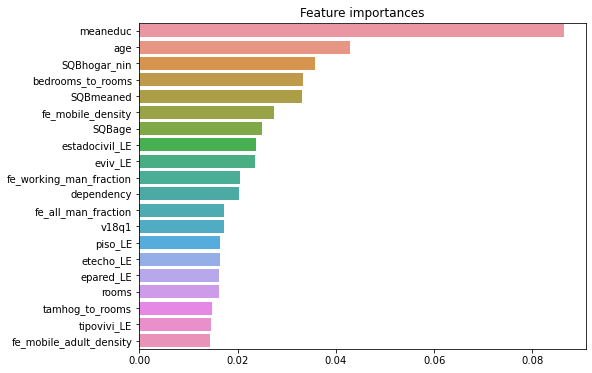

In [76]:
import seaborn as sns
import numpy as np
%matplotlib inline

feature_names = X_train.columns.tolist()[:]

print("Feature importances:\n{0}".format(np.round(dt_clf.feature_importances_,3)))
for name, value in zip(feature_names,dt_clf.feature_importances_):
    print('{0}:{1:.3f}'.format(name,value))

ftr_importances_values = dt_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.drop(et_drop_cols, axis=1).columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top20, y= ftr_top20.index)
plt.show()

In [81]:
params = {'max_depth' : [2,4,6,8,10,12,16,20,24]}
grid_cv = GridSearchCV(dt_clf,param_grid=params, scoring = 'accuracy',cv=5,verbose=1)
grid_cv.fit(X_train.drop(et_drop_cols, axis=1),y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라매터:',grid_cv.best_params_)
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth','mean_test_score']]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.5461
GridSearchCV 최적 하이퍼 파라매터: {'max_depth': 2}


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    2.3s finished


,param_max_depth,mean_test_score
0,2,0.546138
1,4,0.541076
2,6,0.526277
3,8,0.525609
4,10,0.494652
5,12,0.482888
6,16,0.463377
7,20,0.456650
8,24,0.451939


In [83]:
max_depths = [2,4,6,8,10,12,16,20]
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth,random_state=156)
    dt_clf.fit(X_train.drop(et_drop_cols, axis=1),y_train)
    pred = dt_clf.predict(X_test.drop(et_drop_cols, axis=1))
    accuracy = accuracy_score(y_test,pred)
    print('max_depth={0} 정확도: {1:.4f}'.format(depth,accuracy))

max_depth=2 정확도: 0.6225
max_depth=4 정확도: 0.6607
max_depth=6 정확도: 0.6809
max_depth=8 정확도: 0.7663
max_depth=10 정확도: 0.8494
max_depth=12 정확도: 0.9191
max_depth=16 정확도: 0.9820
max_depth=20 정확도: 0.9978


In [84]:
params = {
    'max_depth' : [2,4,6,8,10,12,16,20],
    'min_samples_split' : [10,16,20],
}
grid_cv = GridSearchCV(dt_clf,param_grid=params, scoring = 'accuracy',cv=5,verbose=1)
grid_cv.fit(X_train.drop(et_drop_cols, axis=1),y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.5461
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 2, 'min_samples_split': 10}


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    5.9s finished


In [86]:

best_dt_clf=grid_cv.best_estimator_
pred1 = best_dt_clf.predict(X_test.drop(et_drop_cols, axis=1))
accuarcy = accuracy_score(y_test,pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.9978


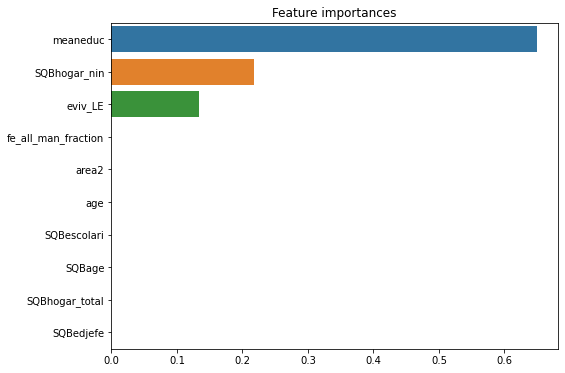

In [89]:
ftr_importances_values = best_dt_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.drop(et_drop_cols, axis=1).columns)
ftr_top10=ftr_importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top10, y= ftr_top10.index)
plt.show()